# Curly hair Anlaysis

* StartDate = Start Date
* EndDate = End Date
* ResponseType = Response type
* IPAddress = IP Address
* Progress = progress
* Duration = Duration(in seconds)
* Finished = Finished
* RecordedDate = Recorded Date
* ResponseID = Response ID
* LName = Recipient Last Name
* FName = Recipient First Name
* Email = Recipient Email
* Reference = External Data Reference
* Latitude = Location Latitude
* Longitude = Location Longitude
* Channel = Distribution Channel
* Language = User Language
* HairLength = How long is your hair?
* DryingTime = How long does your hair typically take to dry?
* ScalpNumber = When parting your hair, how much of your scalp do you see?
* FlakesFrequency = How often do you see white or yellow flakes on your hair?
* HairType = What is your hair type? If your hair is a combination of different types, choose the most common of them.
* ProductStyling = What form of styling product do you prefer? - Selected Choice
* ProductStylingTxt = What form of styling product do you prefer? - None of these, I prefer... - Text
* HairProblem = What are your top 5 hair problems? (Select up to 5)
* BeardProblems = If you have a beard, what are your top 3 beard problems? (Select up to 3)
* ScalpfeelWash = How does your scalp typically feel two or three days after you wash it?
* Strand = Take a single strand of your hair and roll it between your fingers with your eyes closed. What best describes your strand?
* HairGreyed = How much of your hair has greyed?
* HairTreatment = Have you treated your hair with any of these treatments recently or will you soon?
* HairDry = How often do you treat your hair with heat or color-treatments like hair dye?
* ProductSmell = How do you like your products to smell?
* Races = Choose one or more races that you consider yourself to be: - Selected Choice
* RaceTxt = Choose one or more races that you consider yourself to be: - Other - Text
* AgeRange = What is your age range?
* Countries = List of Countries
* Sex = To which gender identity do you most identify? - Selected Choice
* SexTxt = To which gender identity do you most identify? - Prefer to self-describe - Text
* ZipCode = What is your ZIP code?
* productsLaunch = Would you like to be one of the first to know when CURLe first products launch? - Selected Choice
* productsLaunchTxt = Would you like to be one of the first to know when CURLe first products launch? - Yes, here's my email!


# Import Package

In [1]:
import pandas as pd
#import pandas_profiling as pp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=all)
warnings.filterwarnings('ignore')

import plotly as py
import cufflinks as cf
import seaborn as sns
from plotly.offline import iplot
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [2]:
random_state = 5
def is_sig_diff(lower, upper):
    if upper > 0:
        return True if lower > 0 else False # interval contains 0
    if upper < 0:
        return True if lower < 0 else False # interval contains 0
    
def compare_distributions(acc1, acc2):
    t = 2.26 / np.sqrt(len(acc1))

    e = acc1-acc2
    # std1 = np.std(acc1)
    # std2 = np.std(acc2)
    stdtot = np.std(e)

    dbar = np.mean(e)
    #print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
    #print (np.mean(acc1), np.mean(acc2))
    upper =  dbar+t*stdtot
    lower = dbar-t*stdtot
    return {
        'lower':  lower,
        'upper':  upper,
        'mean_1': np.mean(acc1),
        'mean_2': np.mean(acc2),
        'significant': is_sig_diff(lower, upper)
    }



def run_spectral_clustering(train
                           , cols=['longitude', 'latitude', 'Duration', 'ZipCode']
                           , clusters=[5]
                           , affinity_types=['nearest_neighbors']
                           , eigen_solvers=['arpack']
                           , show_map=True):

    assert(len(cols) == 2)
    results = {}
    for n_clusters in clusters:
            for affinity_type in affinity_types:
                for solver in eigen_solvers:
                    X = train[cols].copy()
                    spc = SpectralClustering(n_clusters=n_clusters
                                             , affinity = affinity_type
                                             , random_state=random_state
                                            , n_jobs=-1
                                            , eigen_solver=solver)
                    spec_fit = spc.fit(X)
                    new_feature = spc.labels_
                    y = y_train.values.ravel() # target 
                    X = X_train.drop(columns=cols) #drop the cols that we are using for clustering  
                    X = np.column_stack((X, pd.get_dummies(new_feature))) # new feature set
                    acc = cross_val_score(classifier
                                          ,X 
                                          ,y=y
                                          ,cv=cv)
                    results.update({(affinity_type, n_clusters, solver):{
                                        'cluster': spc,
                                        'solver': solver,
                                        'spec_fit':spec_fit,
                                        'xform_data':X,
                                        'target': y,
                                        'results':acc,
                                        'clusters':n_clusters}
                                   })
                    if show_map:
                        plt.scatter(X_train[cols[0]]
                                    , X_train[cols[1]]
                                    , c=new_feature
                                    , cmap=plt.cm.rainbow
                                    , s=5
                                    , linewidths=0)
                        print (f'Average accuracy = {acc.mean()*100}+-{acc.std()*100}')
                        plt.title(f'Affinity Matrix Type: {affinity_type} Clusters:{n_clusters} Cols:{cols}')
                        plt.show()
    return results 


                    
def generate_color_map(series):
    return {y:x for x,y in enumerate(series.unique())}

def analyze_eigen_values(matrix, title='', eigen_vectors=10):
    eig_vals, eig_vecs = eigsh(matrix, k=eigen_vectors)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()

    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    x=['PC %s' %i for i in range(0,len(eig_vals))]
    df = {
        'variance_explained':var_exp, 
        'cum_var_explained':cum_var_exp,
        'eigen_values': eig_vals,
        'eig_vecs':eig_vecs,
        'eig_pairs':eig_pairs,
        'index':x}
    data_frame = pd.DataFrame({
        'variance_explained':df['variance_explained'],
        'cum_var_explained':df['cum_var_explained'],
        'index':df['index']
    })
    plt.show(sns.barplot(x='variance_explained', y='index', df=data_frame).set_title(f'Explained Variance {title}'))
    plt.show(sns.barplot(x='cum_var_explained', y='index', df=data_frame).set_title(f'Cumulative Variance {title}'))
    return df

In [3]:
df = pd.read_csv("curly.csv") 
summary = df.describe()
print({x: len(df[x].unique()) for x in df.columns})
summary

{'StartDate': 213, 'EndDate': 211, 'ResponseType': 1, 'IPAddress': 193, 'Progress': 1, 'Duration': 161, 'Finished': 1, 'RecordedDate': 212, 'ResponseID': 215, 'Latitude': 122, 'Longitude': 122, 'Channel': 2, 'Language': 1, 'HairLength': 6, 'DryingTime': 3, 'ScalpNumber ': 3, 'FlakesFrequency': 4, 'HairType': 11, 'ProductStyling': 50, 'HairProblem': 182, 'ScalpfeelWash': 4, 'Strand': 4, 'HairGreyed ': 4, 'HairTreatmentChemeical': 11, 'HairTreatment': 6, 'ProductSmell': 7, 'Races': 21, 'AgeRange': 7, 'Countries': 39, 'Sex': 4, 'ZipCode': 127, 'Porosity': 3, 'target_1': 11, 'target': 11}


,Progress,Duration,Latitude,Longitude,ZipCode,target
count,215.0,215.000000,215.000000,215.000000,187.000000,215.000000
mean,100.0,316.981395,33.303169,-91.424061,70077.818182,3.167442
std,0.0,579.704025,6.456523,27.436315,17777.126936,2.455180
min,100.0,112.000000,-37.768402,-156.677200,0.000000,0.000000
25%,100.0,184.000000,32.788895,-96.966648,75025.000000,1.000000
50%,100.0,228.000000,32.864594,-96.788803,75082.000000,3.000000
75%,100.0,309.000000,33.106400,-96.618347,76004.000000,5.000000
max,100.0,8239.000000,51.644897,144.951294,99352.000000,10.000000


In [4]:
# df.head()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StartDate               215 non-null    object 
 1   EndDate                 215 non-null    object 
 2   ResponseType            215 non-null    object 
 3   IPAddress               215 non-null    object 
 4   Progress                215 non-null    int64  
 5   Duration                215 non-null    int64  
 6   Finished                215 non-null    bool   
 7   RecordedDate            215 non-null    object 
 8   ResponseID              215 non-null    object 
 9   Latitude                215 non-null    float64
 10  Longitude               215 non-null    float64
 11  Channel                 215 non-null    object 
 12  Language                215 non-null    object 
 13  HairLength              193 non-null    object 
 14  DryingTime              215 non-null    ob

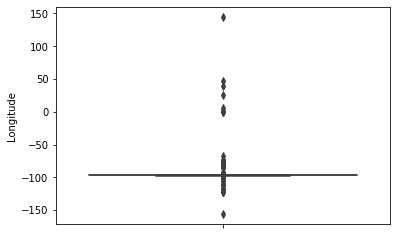

In [6]:
sns.boxplot(y = 'Longitude', data = df)

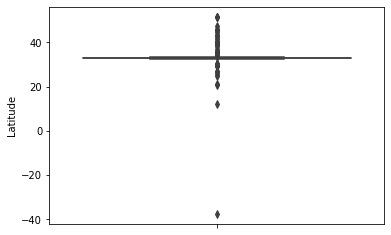

In [7]:
sns.boxplot(y = 'Latitude', data = df)

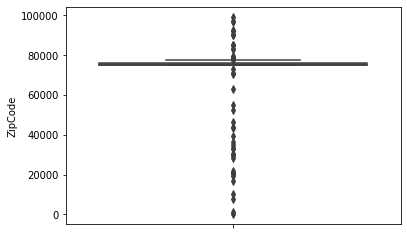

In [8]:
sns.boxplot(y = 'ZipCode', data = df)

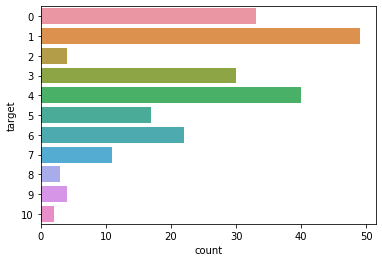

In [9]:
sns.countplot(y='target', data=df)

# Data Preparation


## Remove Attributes

In [10]:
# let's clean the dataset a little before moving on
#  Remove attributes that just arent useful for us
for col in ['ScalpNumber', 'IPAddress', 'StartDate','EndDate','ResponseType','Finished', 'RecordedDate', 'ResponseID', 
            'LName', 'FName', 'Email', 'Reference', 'Language', 'ProductStylingTxt', 'SexTxt',
            'productsLaunch', 'productsLaunchTxt', 'Countries', 'Channel', 'HairTreatmentChemeical', 
            'Progress', 'target_1', ]:
    if col in df:
        del df[col]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Duration         215 non-null    int64  
 1   Latitude         215 non-null    float64
 2   Longitude        215 non-null    float64
 3   HairLength       193 non-null    object 
 4   DryingTime       215 non-null    object 
 5   ScalpNumber      215 non-null    object 
 6   FlakesFrequency  215 non-null    object 
 7   HairType         214 non-null    object 
 8   ProductStyling   215 non-null    object 
 9   HairProblem      215 non-null    object 
 10  ScalpfeelWash    215 non-null    object 
 11  Strand           214 non-null    object 
 12  HairGreyed       215 non-null    object 
 13  HairTreatment    213 non-null    object 
 14  ProductSmell     214 non-null    object 
 15  Races            213 non-null    object 
 16  AgeRange         215 non-null    object 
 17  Sex             

In [12]:
df.head()

,Duration,Latitude,Longitude,HairLength,DryingTime,ScalpNumber,FlakesFrequency,HairType,ProductStyling,HairProblem,...,Strand,HairGreyed,HairTreatment,ProductSmell,Races,AgeRange,Sex,ZipCode,Porosity,target
0,201,32.731903,-96.905701,Mid-back or longer,1-2 hours,Some of my scalp.,Sometimes,3a,"Styling Cream,Mousse,Custard,Oil","Hair Growth,Thinning,Split Ends,Breakage,Rough...",...,Thick and noticeable.,None at all,Rarely,Fruity,Arab or Middle Eastern,18-24,Female,75061.0,Medium,1
1,199,32.896393,-96.863502,Shoulder length,Just a few minutes out of the shower,I have no problem seeing my scalp.,Rarely,2b,Custard,"Thinning,Too Little Volume,Dull hair strands,O...",...,Thin and bendable.,None at all,Once or twice a year,Floral,Arab or Middle Eastern,18-24,Female,75063.0,Low,5
2,450,32.925995,-96.966599,Mid-back or longer,1-2 hours,I have no problem seeing my scalp.,Weekly,3b,"Styling Cream,Custard,Oil","Hair Growth,Frizz,Dandruff,Dull hair strands,R...",...,Thick and noticeable.,None at all,Every few months,Floral,Arab or Middle Eastern,18-24,Female,75063.0,Medium,1
3,218,30.429306,-97.720703,Armpit length,1-2 hours,I have no problem seeing my scalp.,Sometimes,3c,Styling Cream,"Thinning,Frizz,Too Little Volume,Dry Scalp,Che...",...,Thin and bendable.,None at all,Monthly,Fruity,Arab or Middle Eastern,18-24,Female,76137.0,Medium,1
4,156,32.960999,-96.984100,Mid-back or longer,1-2 hours,Some of my scalp.,Daily,3c,Styling Cream,"Hair Growth,Dry Scalp,Dandruff,Breakage,Dull h...",...,Thick and noticeable.,None at all,Rarely,Fruity,Arab or Middle Eastern,18-24,Female,75019.0,Medium,1


## Imputing Missing values
Impact of missing values

* Reduces the efficiency of ML model
* Affects the overall distribution of data values
* It leads to a biased effect in the estimation of the ML model

By imputation, we mean to replace the missing or null values with a particular value in the entire dataset.

Imputation can be done using any of the below techniques–

Impute by mean
Impute by median
Knn Imputation

In [13]:
df.isnull().sum()

Duration            0
Latitude            0
Longitude           0
HairLength         22
DryingTime          0
ScalpNumber         0
FlakesFrequency     0
HairType            1
ProductStyling      0
HairProblem         0
ScalpfeelWash       0
Strand              1
HairGreyed          0
HairTreatment       2
ProductSmell        1
Races               2
AgeRange            0
Sex                 1
ZipCode            28
Porosity            0
target              0
dtype: int64

### 1.  Imputed Continous Variables
Two ways. using mean and median

In [14]:
# Means
# missing_col = ['ZipCode']
#Technique 1: Using mean to impute the missing values
# for i in missing_col:
#  df.loc[df.loc[:,i].isnull(),i] = df.loc[:,i].mean()

In [15]:
# Medians
missing_col = ['ZipCode']
 
#Technique 2: Using median to impute the missing values
for i in missing_col:
 df.loc[df.loc[:,i].isnull(),i] = df.loc[:,i].median()
 
print("count of NULL values after imputation\n")
df.isnull().sum()

count of NULL values after imputation



Duration            0
Latitude            0
Longitude           0
HairLength         22
DryingTime          0
ScalpNumber         0
FlakesFrequency     0
HairType            1
ProductStyling      0
HairProblem         0
ScalpfeelWash       0
Strand              1
HairGreyed          0
HairTreatment       2
ProductSmell        1
Races               2
AgeRange            0
Sex                 1
ZipCode             0
Porosity            0
target              0
dtype: int64

### 2.  Imputing Categorical Values

Methods

* Delete the rows
* Replace with the most frequent values
* apply classifier algorithm to predict
* Apply Unsupervised ML

Missed values for our categorical values are:

* HairLength = 22
* HairType   = 1
* HairTreatment = 2
* Strand     = 1
* Races      = 2
* Sex        = 1

In [16]:
df['HairLength'].value_counts()

Armpit length                64
Mid-back or longer           50
Shoulder length              48
Above the ear or shoulder    25
Chin length                   6
Name: HairLength, dtype: int64

In [17]:
df['HairLength'].value_counts().index[0]

'Armpit length'

In [18]:
df['HairType'].value_counts()

2b    36
3b    35
2c    34
3a    31
3c    19
2a    17
4a    17
4c    11
4b     8
1      6
Name: HairType, dtype: int64

In [19]:
df['HairType'].value_counts().index[0]

'2b'

In [20]:
df['HairTreatment'].value_counts()

Rarely                  112
Every few months         40
Once or twice a year     39
Monthly                  16
Weekly                    6
Name: HairTreatment, dtype: int64

In [21]:
df['HairTreatment'].value_counts().index[0]

'Rarely'

In [22]:
df['Strand'].value_counts()

Thin and bendable.          112
Thick and noticeable.        82
I can't feel the strand.     20
Name: Strand, dtype: int64

In [23]:
df['Strand'].value_counts().index[0]

'Thin and bendable.'

In [24]:
df['Sex'].value_counts()

Female                    188
Male                       25
Prefer to not describe      1
Name: Sex, dtype: int64

In [25]:
df['Sex'].value_counts().index[0]

'Female'

In [26]:
df['Races'].value_counts()

Arab or Middle Eastern                                                    65
White                                                                     49
Black or African American                                                 41
South Asian                                                               21
Asian                                                                     10
White,Other                                                                5
White,Black or African American                                            4
Other                                                                      3
White,South Asian                                                          2
Asian,South Asian                                                          2
White,American Indian or Alaska Native                                     2
Arab or Middle Eastern,Other                                               1
Arab or Middle Eastern,South Asian                                         1

In [27]:
df['Races'].value_counts().index[0]

'Arab or Middle Eastern'

In [28]:
df['ProductSmell'].value_counts()

Fresh        84
Floral       54
Fruity       41
Unscented    19
Musk         12
Spice         4
Name: ProductSmell, dtype: int64

In [29]:
df['ProductSmell'].value_counts().index[0]

'Fresh'

In [30]:
df['Porosity'].value_counts()

Medium    104
High       85
Low        26
Name: Porosity, dtype: int64

In [31]:
df['Porosity'].value_counts().index[0]

'Medium'

In [32]:
#df['target'].value_counts()

In [33]:
# df['target'].value_counts()

In [34]:
df['Sex'].fillna(df['Sex'].value_counts().index[0], inplace = True)
df['HairLength'].fillna(df['HairLength'].value_counts().index[0], inplace = True)
df['HairType'].fillna(df['HairType'].value_counts().index[0], inplace = True)
df['Strand'].fillna(df['Strand'].value_counts().index[0], inplace = True)
df['HairTreatment'].fillna(df['HairTreatment'].value_counts().index[0], inplace = True)
df['Races'].fillna(df['Races'].value_counts().index[0], inplace = True)
df['ProductSmell'].fillna(df['ProductSmell'].value_counts().index[0], inplace = True)
df['ScalpfeelWash'].fillna(df['ScalpfeelWash'].value_counts().index[0], inplace = True)
df['Porosity'].fillna(df['Porosity'].value_counts().index[0], inplace = True)
#df['target'].fillna(df['target'].value_counts().index[0], inplace = True)


In [35]:
df.isnull().sum()

Duration           0
Latitude           0
Longitude          0
HairLength         0
DryingTime         0
ScalpNumber        0
FlakesFrequency    0
HairType           0
ProductStyling     0
HairProblem        0
ScalpfeelWash      0
Strand             0
HairGreyed         0
HairTreatment      0
ProductSmell       0
Races              0
AgeRange           0
Sex                0
ZipCode            0
Porosity           0
target             0
dtype: int64

In [36]:
#df.info()

## Duplications

Checking Duplication Valuesduplication values

In [37]:
dfDups = df[df.duplicated()]
dfDups

,Duration,Latitude,Longitude,HairLength,DryingTime,ScalpNumber,FlakesFrequency,HairType,ProductStyling,HairProblem,...,Strand,HairGreyed,HairTreatment,ProductSmell,Races,AgeRange,Sex,ZipCode,Porosity,target


## Outliers
Outliers are not important for 
 * categorical variables 
 * for fariables like ID

So in our case -- latitude, longitude and zip are Numeric variavbles and we would do the outline on these

In [38]:
# select the wanted columns
df_quantitative = df[['Duration', 'Latitude', 'Longitude', 'ZipCode']]

In [39]:
df_quantitative.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

,Duration,Latitude,Longitude,ZipCode
count,215.000000,215.000000,215.000000,215.000000
mean,316.981395,33.303169,-91.424061,70729.525581
std,579.704025,6.456523,27.436315,16659.135896
min,112.000000,-37.768402,-156.677200,0.000000
1%,119.420000,20.988705,-122.582226,8116.640000
5%,137.700000,29.632043,-110.739304,29522.400000
25%,184.000000,32.788895,-96.966648,75035.000000
50%,228.000000,32.864594,-96.788803,75082.000000
75%,309.000000,33.106400,-96.618347,75240.500000
95%,482.600000,41.689929,-74.879050,83604.600000


# Visualization

Text(0.5, 0, 'Porosity and hairtype, fontsize = 14')

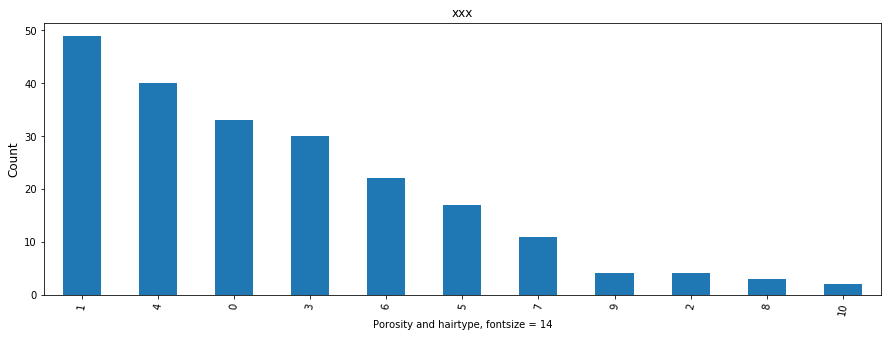

In [40]:
#plt.figure(figsize=(6,4))
age = df.target.value_counts()
age.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Porosity and hairtype, fontsize = 14')


In [41]:
# reference: https://plot.ly/python/line-and-scatter/
regions_dict = {value: i for i,value in enumerate(df.target.unique())}
reverse_regions_dict = {i:v for v,i in regions_dict.items()}
df = df.applymap(lambda s: regions_dict.get(s) if s in regions_dict.keys() else s)

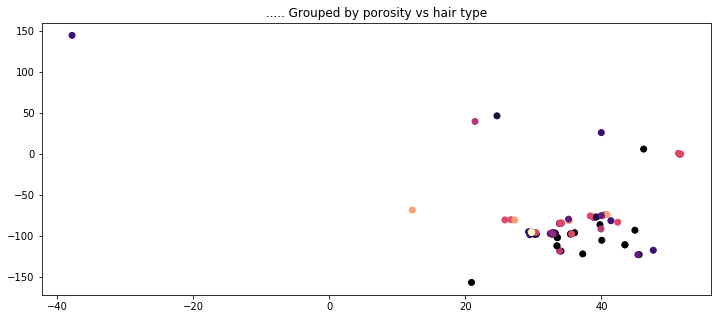

In [42]:
# reference: https://plot.ly/python/line-and-scatter/
plt.figure(figsize=(12, 5))
plt.scatter(df.Latitude, df.Longitude, c = df.target, cmap='magma')
plt.title('..... Grouped by porosity vs hair type')
# plt.legend()
plt.show()

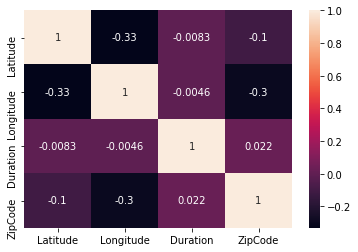

In [43]:
sns.heatmap(df[['Latitude','Longitude','Duration','ZipCode']].corr(),annot=True)
plt.show()

There is no correoation problem at all

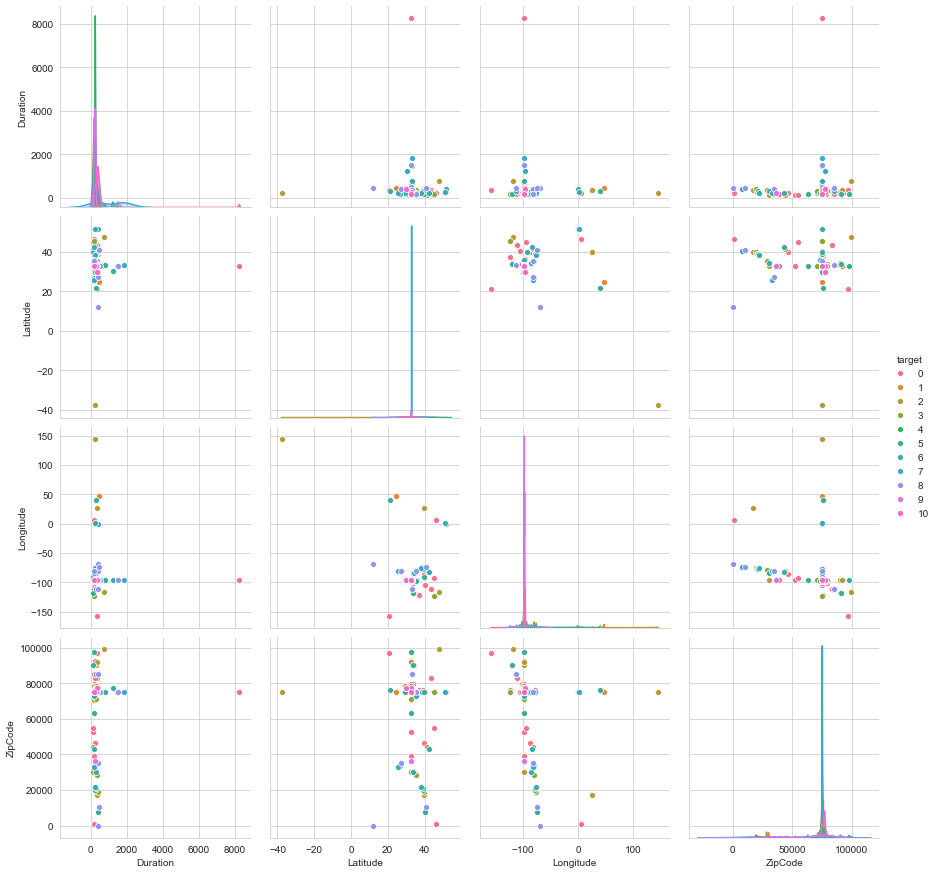

In [44]:
plt.close()
sns.set_style('whitegrid')
sns.pairplot(df, hue='target', height=3)
plt.show()

Text(0.5, 0, 'Age Range, fontsize = 12')

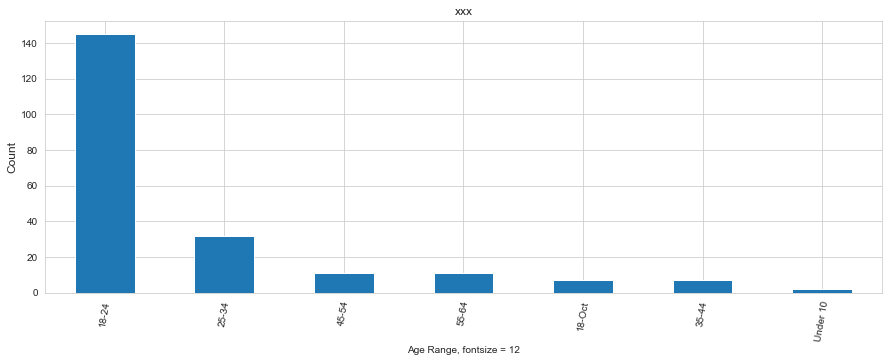

In [45]:
#plt.figure(figsize=(6,4))
age = df.AgeRange.value_counts()
age.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Age Range, fontsize = 12')


Text(0.5, 0, 'Sex')

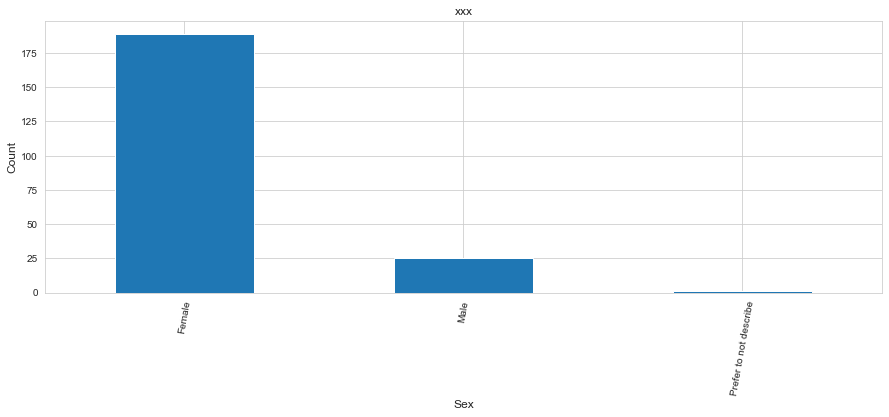

In [46]:
#plt.figure(figsize=(6,4))
sex = df.Sex.value_counts()
sex.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Sex', fontsize = 12)


Text(0.5, 0, 'Races group')

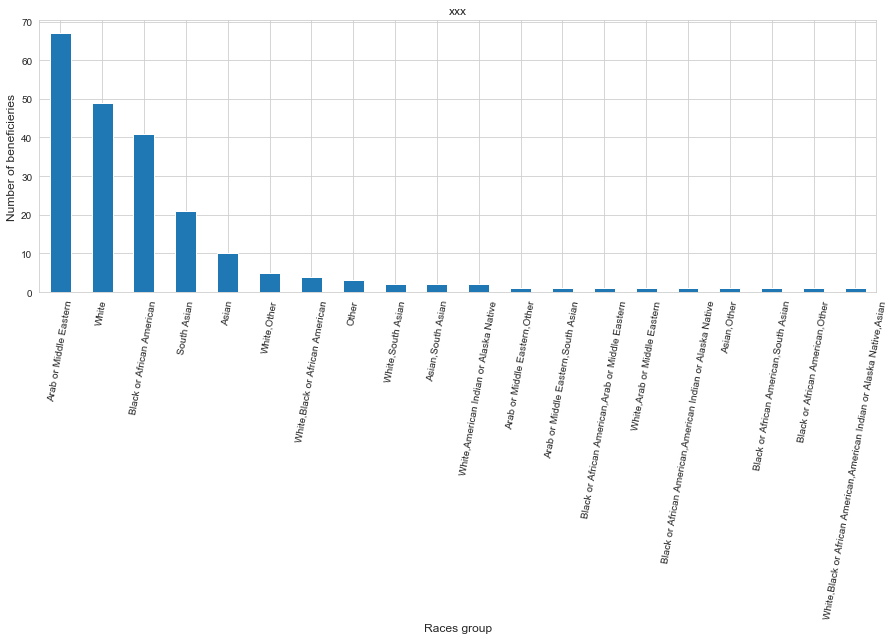

In [47]:
#plt.figure(figsize=(6,4))
races = df.Races.value_counts()
races.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Number of beneficieries', fontsize = 12)
plt.xlabel('Races group', fontsize = 12)

Text(0.5, 0, 'Hair Length group')

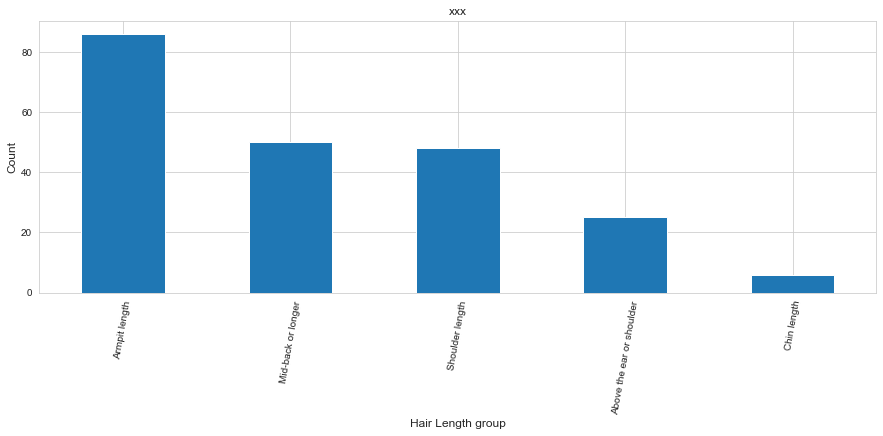

In [48]:
#plt.figure(figsize=(6,4))
Howlonghair = df.HairLength.value_counts()
Howlonghair.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Hair Length group', fontsize = 12)

Text(0.5, 0, 'Hair type group')

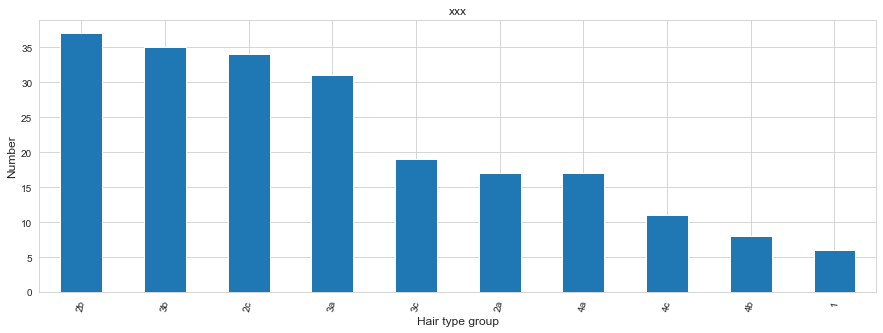

In [49]:
hairtype = df.HairType.value_counts()
hairtype.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Number', fontsize = 12)
plt.xlabel('Hair type group', fontsize = 12)

In [50]:
# Channel = df.Channel.value_counts()
# Channel.plot.bar(figsize = (15, 5), rot = 80)
# plt.title('xxx', fontsize = 12)
# plt.ylabel('Count', fontsize = 12)
# plt.xlabel('Distribution Channel group', fontsize = 12)

Text(0.5, 0, 'Beneficieries Hair Length')

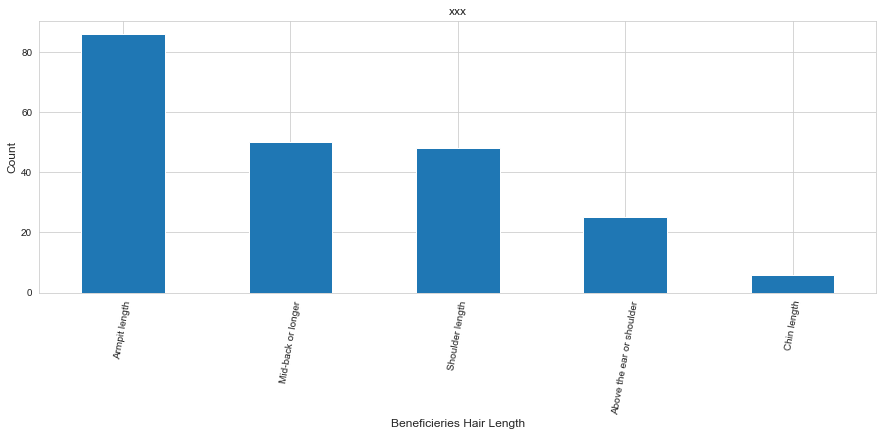

In [51]:
HairLength = df.HairLength.value_counts()
HairLength.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Beneficieries Hair Length', fontsize = 12)

Text(0.5, 0, 'Hair Drying time')

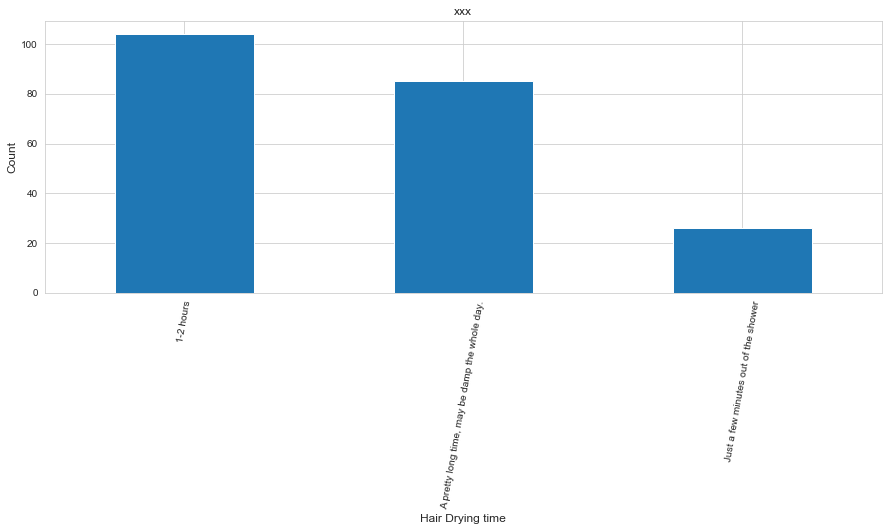

In [52]:
DryingTime = df.DryingTime.value_counts()
DryingTime.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Hair Drying time', fontsize = 12)

Text(0.5, 0, 'The white or yellow flakes frequency')

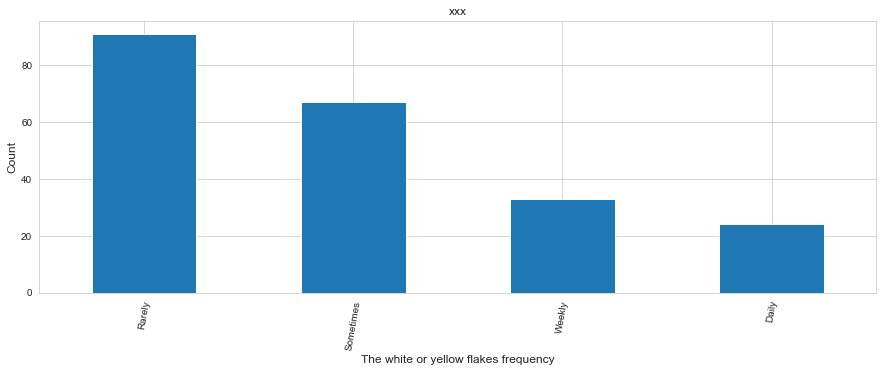

In [53]:
FlakesFrequency = df.FlakesFrequency.value_counts()
FlakesFrequency.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('The white or yellow flakes frequency', fontsize = 12)

Text(0.5, 0, 'Hair type')

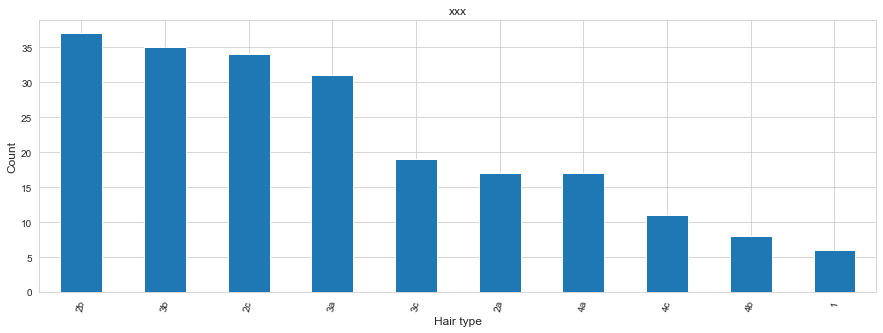

In [54]:
HairType = df.HairType.value_counts()
HairType.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Hair type', fontsize = 12)

Text(0.5, 0, 'Product Styling group')

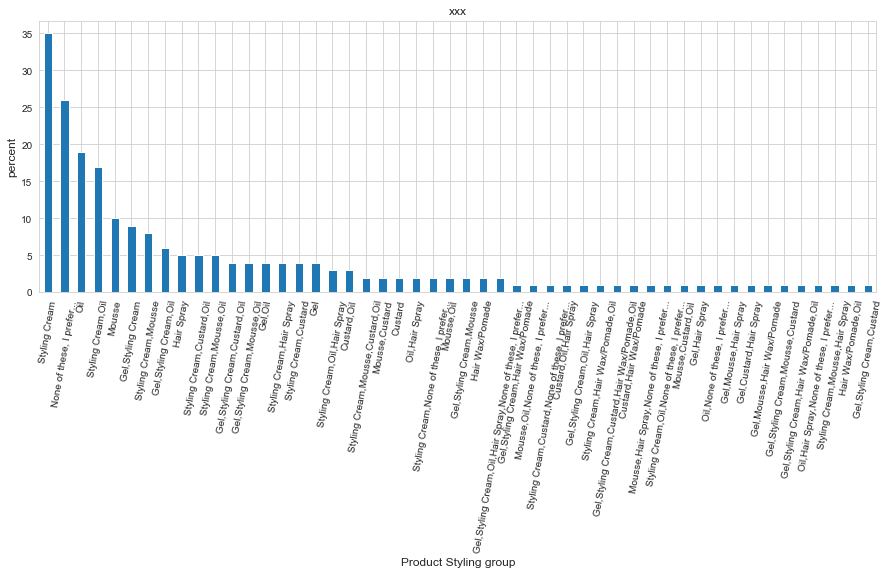

In [55]:
ProductStyling = df.ProductStyling.value_counts()
ProductStyling.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('percent', fontsize = 12)
plt.xlabel('Product Styling group', fontsize = 12)

Text(0.5, 0, 'Scalp feel Wash group')

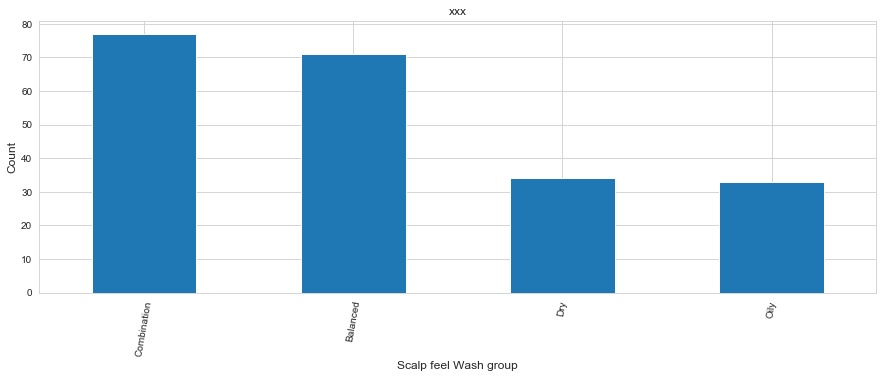

In [56]:
ScalpfeelWash = df.ScalpfeelWash.value_counts()
ScalpfeelWash.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Scalp feel Wash group', fontsize = 12)

Text(0.5, 0, 'Strand group')

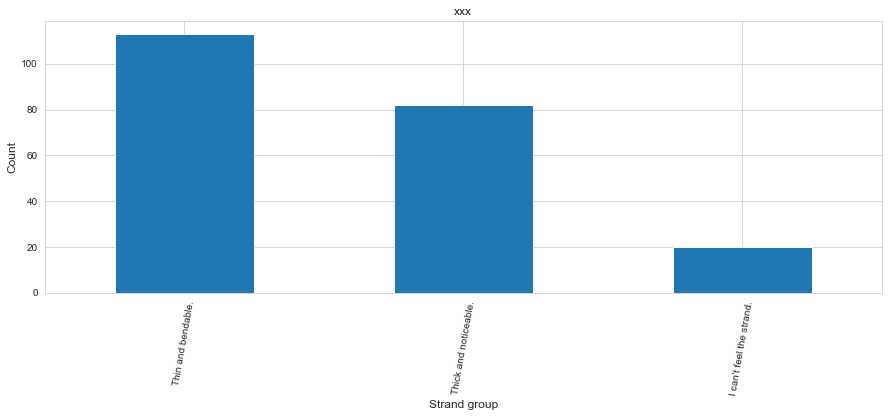

In [57]:
Strand = df.Strand.value_counts()
Strand.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Strand group', fontsize = 12)

Text(0.5, 0, 'Hair Treatment')

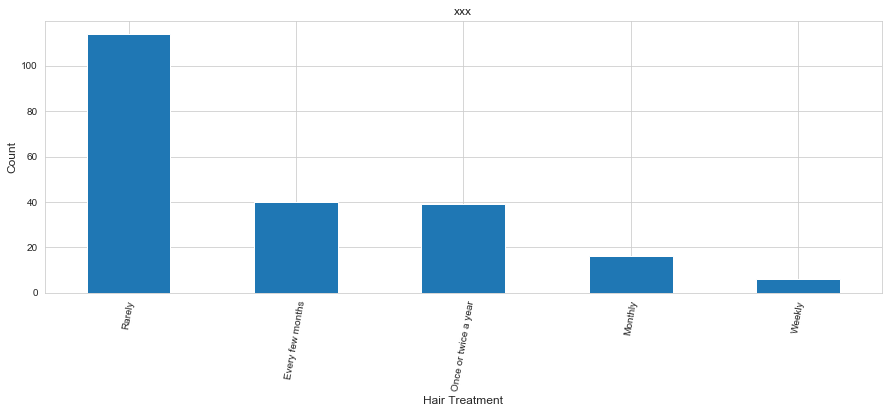

In [58]:
HairTreatment = df.HairTreatment.value_counts()
HairTreatment.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Hair Treatment', fontsize = 12)

Text(0.5, 0, 'Product Smell group')

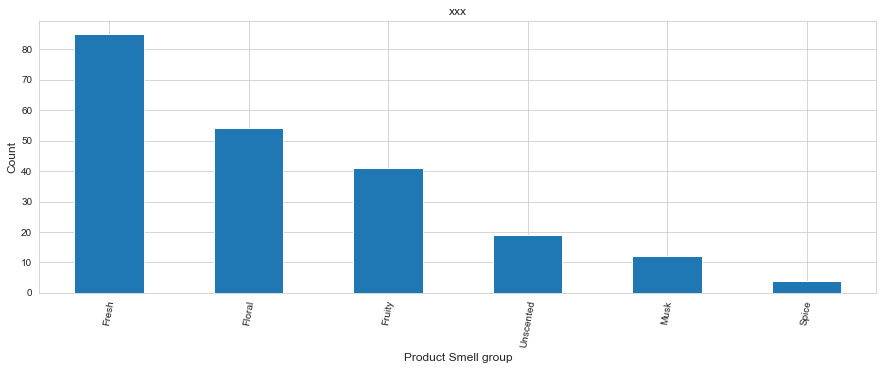

In [59]:
ProductSmell = df.ProductSmell.value_counts()
ProductSmell.plot.bar(figsize = (15, 5), rot = 80)
plt.title('xxx', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Product Smell group', fontsize = 12)

In [60]:
# df.info()

# Type Conversion

In [61]:
# df['target'] = df['target'].map({'curly_High': 0,
#                                 'curly_Medium' : 1,
#                                 'curly_Low': 2,
#                                 'wavy_High': 3,
#                                 'wavy_Medium' : 4,
#                                 'wavy_Low' : 5, 
#                                 'coils_High': 6, 
#                                 'coils_Medium': 7,
#                                 'coils_Low': 8, 
#                                 'Straight_Medium': 9,
#                                 'Straight_low ': 10,
#                                }).astype(int)



In [62]:
# df['target'] = df['target'].astype(int, errors='ignore')

In [63]:
df['Duration'] = df['Duration'].astype('float64')
df['ZipCode'] = df['ZipCode'].astype('float64')
df['Latitude'] = df['Latitude'].astype('float64')
df['Longitude'] = df['Longitude'].astype('float64')
df['HairLength'] = df['HairLength'].astype('category')
df['DryingTime'] = df['DryingTime'].astype('category')
df['FlakesFrequency'] = df['FlakesFrequency'].astype('category')
df['ScalpfeelWash'] = df['ScalpfeelWash'].astype('category')
df['ProductStyling'] = df['ProductStyling'].astype('category')
df['HairProblem'] = df['HairProblem'].astype('category')
df['Strand'] = df['Strand'].astype('category')
df['HairGreyed '] = df['HairGreyed '].astype('category')
df['HairTreatment'] = df['HairTreatment'].astype('category')
df['ProductSmell'] = df['ProductSmell'].astype('category')
df['Races'] = df['Races'].astype('category')
df['AgeRange'] = df['AgeRange'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['HairType'] = df['HairType'].astype('category')
df['Porosity'] = df['Porosity'].astype('category')
#df['target'] = df['target'].astype('category')


In [66]:
# df.info()

In [67]:
from sklearn.preprocessing import StandardScaler
std_scale =  StandardScaler()

In [68]:
df['Duration'] = std_scale.fit_transform(df[['Duration']])
df['Latitude'] = std_scale.fit_transform(df[['Latitude']])
df['Longitude'] = std_scale.fit_transform(df[['Longitude']])
df['ZipCode'] = std_scale.fit_transform(df[['ZipCode']])

In [69]:
# df.info()

###  One Hot Encoding with Pandas

In [70]:
df_dummies = pd.get_dummies(df[['HairLength', 'DryingTime', 'FlakesFrequency', 
                                'HairType', 'ProductStyling', 'HairProblem', 
                                'ScalpfeelWash', 'Strand', 'HairTreatment', 
                                'ProductSmell', 'Races', 
                                'AgeRange', 'Sex', 'Porosity',]])

In [71]:
df = pd.concat([df[['Duration', 'Latitude', 'Longitude', 'ZipCode', 'target']], df_dummies], axis=1)

In [72]:
df.head()

,Duration,Latitude,Longitude,ZipCode,target,HairLength_Above the ear or shoulder,HairLength_Armpit length,HairLength_Chin length,HairLength_Mid-back or longer,HairLength_Shoulder length,...,AgeRange_35-44,AgeRange_45-54,AgeRange_55-64,AgeRange_Under 10,Sex_Female,Sex_Male,Sex_Prefer to not describe,Porosity_High,Porosity_Low,Porosity_Medium
0,-0.200537,-0.088685,-0.200261,0.260613,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,-0.203995,-0.063149,-0.198720,0.260733,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0.229995,-0.058554,-0.202486,0.260733,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,-0.171143,-0.446149,-0.230036,0.325353,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,-0.278344,-0.053120,-0.203126,0.258086,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


# Building Machine Learning

# Classtering

# Data Analysis

In [73]:
X = df.drop("target", axis=1)
y = df["target"]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) # 70% training and 30% test

In [75]:
# Feature Scaling
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)


In [76]:
X_train.shape

(150, 309)

In [77]:
X_test.shape

(65, 309)

In [78]:
y_train.shape

(150,)

In [79]:
y_train.shape

(150,)

#### 1. KNN

In [80]:
knn_classifier = KNeighborsClassifier(n_neighbors = 3 , metric='minkowski' , p=2)
knn_classifier.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [81]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
y_pred = knn_clf.predict(X_test)
y_pred

array([ 0,  3,  0,  6,  1,  5,  2,  0,  1,  6,  1,  3,  3,  3,  0,  3,  0,
        1,  2,  6,  3,  0,  0,  3,  2,  5,  0,  3,  1,  2,  0, 10,  3,  3,
        6,  2,  0,  2,  2,  3,  0,  3,  2,  0,  5,  2,  0,  5,  2,  0,  6,
        1,  3,  2,  6,  0,  5,  0,  0,  0,  0,  0,  5,  5,  2],
      dtype=int64)

In [82]:
knn_clf = KNeighborsClassifier(n_neighbors = 3 , metric='minkowski' , p=2)
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [83]:
y_pred = knn_clf.predict(X_test)

In [84]:
acc_clf = knn_clf.score(X_train,y_train)
print(round(acc_clf*100, 2), "%")

82.0 %


In [85]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test, y_pred)
print("Accuracy:", result2)

Confusion Matrix:
[[9 0 5 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0]
 [8 0 5 0 1 0 0 0 0]
 [0 0 0 5 2 0 0 0 0]
 [0 0 2 4 5 0 0 0 0]
 [0 0 0 4 0 4 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.64      0.53        14
           1       0.71      1.00      0.83         5
           2       0.38      0.36      0.37        14
           3       0.38      0.71      0.50         7
           5       0.62      0.45      0.53        11
           6       1.00      0.50      0.67         8
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.51        65
   macro avg       0.40      0.41      0.38        65
weighted avg       0.50      0.51      0.48        65

Accuracy: 0.5076923076923077


In [86]:
cm = confusion_matrix(y_test, y_pred)


### 2. Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [88]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
#print(round(acc_random_forest,2,), "%")

In [89]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")

In [90]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.8        0.8        0.8        0.86666667 0.93333333 0.93333333
 0.93333333 0.86666667 0.86666667 0.93333333]
Mean: 0.8733333333333334
Standard Deviation: 0.05537749241945382


### Feature Importance

### 3. XGBoos Classifier

# Clustering